In [68]:
#Solves the SSD set of equations

#eqn : du/dt = R - r_m*U
#eqn : R = 0.25 * k * (k_plus_square - k_e_square) * C_13 
#eqn : dC/dt = A(U)*C + C*Transpose(A(U)) + eps*Q
#eqn : A(U) = W + UL

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
import random
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from pandas.plotting import parallel_coordinates


In [69]:

class Simulation:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time, U, C, current_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m
        self.k = k
        self.m = m
        self.m_u = m_u
        # self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.C = C

        self.current_time = current_time

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0

        self.C_History = np.zeros((self.num_steps, 4, 4)) 
        self.delta_C_History = np.zeros((self.num_steps, 4, 4)) 

        # self.C_History = np.zeros(self.num_steps)

        self.U_History = np.zeros(self.num_steps)
        self.delta_U_History = np.zeros(self.num_steps)

        self.R_History = np.zeros(self.num_steps)

        self.C = self.C.astype(np.float64)
        self.delta_C_History = self.delta_C_History.astype(np.float64)

        self.U_star = np.array(0.3973011053455921)
        self.C_star = np.array([[ 8.05473382e-05, -8.55442403e-03,  1.17340387e-06, -1.24657177e-02],
                                [-8.55442403e-03,  5.45454501e+01,  7.80414655e-03, -6.44767926e+00],
                                [ 1.17340387e-06,  7.80414655e-03,  1.60960793e-05, -2.32919463e-03],
                                [-1.24657177e-02, -6.44767926e+00, -2.32919463e-03,  2.02873504e+01]])
        
        self.delta_U = U - self.U_star
        self.delta_C = C - self.C_star

        self.delta_C_dot = self.delta_U * np.block([[self.zero_arrays, self.L_e_plus], [self.L_plus_e, self.zero_arrays]]) @ self.C_star + np.block([[self.W_e, self.zero_arrays], [self.zero_arrays, self.W_plus]]) @ self.delta_C + \
                            self.U_star * np.block([[self.zero_arrays, self.L_e_plus], [self.L_plus_e, self.zero_arrays]]) @ self.delta_C + self.delta_U * self.C_star @ np.transpose(np.block([[self.zero_arrays, self.L_e_plus], [self.L_plus_e, self.zero_arrays]])) + \
                            self.delta_C @ np.transpose(np.block([[self.W_e, self.zero_arrays], [self.zero_arrays, self.W_plus]])) + self.U_star * self.delta_C @ np.transpose(np.block([[self.zero_arrays, self.L_e_plus], [self.L_plus_e, self.zero_arrays]]))

        self.delta_C_dot_History = np.zeros((self.num_steps, 4, 4)) 
        self.delta_C_dot_History = self.delta_C_dot_History.astype(np.float64)

        self.delta_U_dot = (1/4)*self.k * (self.k_plus_square - self.k_e_square) * self.delta_C[0][2] - self.r_m * self.delta_U
        self.delta_U_History = np.zeros(self.num_steps)

        self.C_tot = np.zeros((self.num_steps, 4, 4)) 
        self.C_tot = self.C_tot.astype(np.float64)

        self.U_tot = np.zeros(self.num_steps)

    def simulate(self):
        for i in range(self.num_steps):
            
            # self.C_tot[i] = self.C_star + self.delta_C_dot 
            # self.U_tot[i] = self.U_star + self.delta_U_dot

            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 


            self.delta_C_dot = self.delta_U * np.block([[self.zero_arrays, self.L_e_plus], [self.L_plus_e, self.zero_arrays]]) @ self.C_star + np.block([[self.W_e, self.zero_arrays], [self.zero_arrays, self.W_plus]]) @ self.delta_C + \
                            self.U_star * np.block([[self.zero_arrays, self.L_e_plus], [self.L_plus_e, self.zero_arrays]]) @ self.delta_C + self.delta_U * self.C_star @ np.transpose(np.block([[self.zero_arrays, self.L_e_plus], [self.L_plus_e, self.zero_arrays]])) + \
                            self.delta_C @ np.transpose(np.block([[self.W_e, self.zero_arrays], [self.zero_arrays, self.W_plus]])) + self.U_star * self.delta_C @ np.transpose(np.block([[self.zero_arrays, self.L_e_plus], [self.L_plus_e, self.zero_arrays]]))
            # self.delta_C += self.delta_C_dot * self.dt

            self.delta_U_dot = .25 * self.k * (self.k_plus_square - self.k_e_square) * self.delta_C[0][2] - self.r_m * self.delta_U 
            # self.delta_U += self.delta_U_dot * self.dt
            if i == 0:
                print(self.delta_U_dot)

            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            

            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]
            self.delta_U += self.delta_U_dot * self.dt 
            self.delta_C += self.delta_C_dot * self.dt 

            self.C_tot[i] = self.C_star + self.delta_C 
            self.U_tot[i] = self.U_star + self.delta_U
            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

            self.delta_U_History[i] = self.delta_U
            self.delta_C_History[i] = self.delta_C

            # self.C_tot[i] = self.C_star + self.delta_C_dot 
            # self.U_tot[i] = self.U_star + self.delta_U_dot

            
            



In [70]:

def make_plots(sims):

    time_array = np.arange(0, sims[0].total_time, .001)
    fig, axs = plt.subplots(10, 2, figsize = (20, 65))

    for i in range(10):
        axs[i, 0].plot(time_array, sims[i].U_History)
        axs[i, 0].set_title(f"U History at {sims[i].current_time}")
        axs[i, 0].grid()
        axs[i, 1].plot(time_array, sims[i].R_History)
        axs[i, 1].set_title(f"R Values at {sims[i].current_time}")
        axs[i, 1].grid()

    plt.subplots_adjust(wspace=.4)
    plt.subplots_adjust(hspace=.4)

    plt.show()


In [71]:

epsilon = 0.12394270273516043
N_0_squared = 318.8640217310387
r_m = 0.1
k = 2 * np.pi * 6
m = 2 * np.pi * 3
m_u = 2 * np.pi * 7
dt = 0.001
total_time = 200

k_e_square = k**2 + m**2

C_11 = (2*epsilon/k_e_square)*(2-(np.square(k) * N_0_squared/(k_e_square + np.square(k)*N_0_squared)))
C_12 = -(2*epsilon*k*N_0_squared)/(k_e_square + np.square(k)*N_0_squared)
C_22 = (2*epsilon*np.square(k)*np.square(N_0_squared))/(k_e_square + np.square(k)*N_0_squared)


U_entries = np.array([0.55053473999083])
C_entries = np.array([[[0.0001490152423865438,
-0.056342960706027546,
4.705459608940639e-06,
-0.023997387342599555],
[-0.056342960706027546,
153.61445123375822,
-0.043334023121050586,
-12.060326483759946],
[4.705459608940639e-06,
-0.043334023121050586,
4.7701541745783226e-05,
-0.01911624053635777],
[-0.023997387342599555,
-12.060326483759946,
-0.01911624053635777,
56.7986445738767]]])

current_time_entries = np.array([473])
sims = []

for i in range(len(current_time_entries)):
  sim = Simulation(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time, U_entries[i], C_entries[i], current_time_entries[i])
  sim.simulate()
  sims.append(sim)
# make_plots(sims)


0.10426799659655922


In [72]:
# print(len(sims[0].C_History))

sims[0].U_History = sims[0].U_History[0::10]
sims[0].R_History = sims[0].R_History[0::10]    
sims[0].C_History = sims[0].C_History[0::10]
sims[0].C_tot = sims[0].C_tot[0::10]
sims[0].U_tot = sims[0].U_tot[0::10]
len(sims[0].C_History)
sims[0].C_History


array([[[ 1.46695267e-04, -5.41413958e-02,  2.94246021e-06,
         -2.31805408e-02],
        [-5.41413958e-02,  1.54411499e+02, -4.34004157e-02,
         -1.32733395e+01],
        [ 2.94246021e-06, -4.34004157e-02,  4.78717173e-05,
         -1.84463910e-02],
        [-2.31805408e-02, -1.32733395e+01, -1.84463910e-02,
          5.64757669e+01]],

       [[ 1.33014980e-04, -3.02806163e-02, -1.47762761e-05,
         -1.97863142e-02],
        [-3.02806163e-02,  1.57826785e+02, -4.20643451e-02,
         -2.60209473e+01],
        [-1.47762761e-05, -4.20643451e-02,  4.90954143e-05,
         -1.16898398e-02],
        [-1.97863142e-02, -2.60209473e+01, -1.16898398e-02,
          5.55897174e+01]],

       [[ 1.36561496e-04, -6.97355441e-03, -3.15417472e-05,
         -2.49968310e-02],
        [-6.97355441e-03,  1.52916815e+02, -3.71901707e-02,
         -3.78652495e+01],
        [-3.15417472e-05, -3.71901707e-02,  4.94775370e-05,
         -5.37691256e-03],
        [-2.49968310e-02, -3.78652495e+

In [73]:
db_username_0 = 'simulationuser'
db_password_0 = 'simulations2024'
db_host_0 = 'localhost'
db_port_0 = '5432'
db_name_0 = 'simulations_data'
table_name_0 = 'composite_data'

connection_string = f"postgresql://{db_username_0}:{db_password_0}@{db_host_0}:{db_port_0}/{db_name_0}"
engine = create_engine(connection_string)
query = f"SELECT * FROM {table_name_0}"
df = pd.read_sql(query, engine)


In [74]:

def average_arrays(*arrays):
    if not arrays:
        raise ValueError("No arrays provided for averaging.")
    
    np_arrays = [np.array(arr) for arr in arrays]
    array_lengths = [len(arr) for arr in np_arrays]

    if len(set(array_lengths)) != 1:
        raise ValueError("All input arrays must have the same length.")
    
    average_array = np.mean(np_arrays, axis=0)
    
    return average_array


average_psi_e = average_arrays(*list(df['psi_e']))
average_b_e = average_arrays(*list(df['b_e']))
average_psi_plus = average_arrays(*list(df['psi_plus']))
average_b_plus = average_arrays(*list(df['b_plus']))
average_U = average_arrays(*list(df['u_list']))
average_R = average_arrays(*list(df['r_list']))

average_k_e_psi_e_list = average_arrays(*list(df['k_e_psi_e_list']))
average_k_e_b_e_list = average_arrays(*list(df['k_e_b_e_list']))
average_k_e_psi_plus_list = average_arrays(*list(df['k_e_psi_plus_list']))
average_k_e_b_plus_list = average_arrays(*list(df['k_e_b_plus_list']))
average_heat_flux_psi_e_b_e_list = average_arrays(*list(df['heat_flux_psi_e_b_e_list']))
average_heat_flux_psi_e_b_plus_list = average_arrays(*list(df['heat_flux_psi_e_b_plus_list']))
average_b_e_psi_plus_list = average_arrays(*list(df['b_e_psi_plus_list']))
average_b_e_b_plus_list = average_arrays(*list(df['b_e_b_plus_list']))
average_psi_plus_b_plus_list = average_arrays(*list(df['psi_plus_b_plus_list']))
average_eta = average_arrays(*list(df['eta_list']))

In [75]:
average_psi_e = average_psi_e[473:]
average_b_e = average_b_e[473:]
average_psi_plus = average_psi_plus[473:]
average_b_plus = average_b_plus[473:]
average_U = average_U[473:]
average_R = average_R[473:]

average_k_e_psi_e_list = average_k_e_psi_e_list[473:]
average_k_e_b_e_list = average_k_e_b_e_list[473:]
average_k_e_psi_plus_list = average_k_e_psi_plus_list[473:]
average_k_e_b_plus_list = average_k_e_b_plus_list[473:]
average_heat_flux_psi_e_b_e_list = average_heat_flux_psi_e_b_e_list[473:]
average_heat_flux_psi_e_b_plus_list = average_heat_flux_psi_e_b_plus_list [473:]
average_b_e_psi_plus_list = average_b_e_psi_plus_list[473:]
average_b_e_b_plus_list = average_b_e_b_plus_list [473:]
average_psi_plus_b_plus_list = average_psi_plus_b_plus_list[473:]

In [76]:
U_CMat = sims[0].U_History[0:527]
R_CMat= sims[0].R_History[0:527]
U_tot_list = sims[0].U_tot[0:527]


k_e_psi_e_list_CMat = [sims[0].C_History[i][0][0] for i in range(1000)]
k_e_b_e_list_CMat = [sims[0].C_History[i][1][1] for i in range(1000)]
k_e_psi_plus_list_CMat= [sims[0].C_History[i][2][2] for i in range(1000)]
k_e_b_plus_list_CMat = [sims[0].C_History[i][3][3] for i in range(1000)]
heat_flux_psi_e_b_e_list_CMat = [sims[0].C_History[i][0][1] for i in range(1000)]
heat_flux_psi_e_b_plus_list_CMat = [sims[0].C_History[i][0][3] for i in range(1000)]
b_e_psi_plus_list_CMat = [sims[0].C_History[i][2][1] for i in range(1000)]
b_e_b_plus_list_CMat = [sims[0].C_History[i][1][3] for i in range(1000)]
psi_plus_b_plus_list_CMat = [sims[0].C_History[i][3][2] for i in range(1000)]
psi_e_psi_plus_list_CMat = [sims[0].C_History[i][2][0] for i in range(1000)]


k_e_psi_e_list_CTot = [sims[0].C_tot[i][0][0] for i in range(1000)]
k_e_b_e_list_CTot = [sims[0].C_tot[i][1][1] for i in range(1000)]
k_e_psi_plus_list_CTot= [sims[0].C_tot[i][2][2] for i in range(1000)]
k_e_b_plus_list_CTot = [sims[0].C_tot[i][3][3] for i in range(1000)]
heat_flux_psi_e_b_e_list_CTot = [sims[0].C_tot[i][0][1] for i in range(1000)]
heat_flux_psi_e_b_plus_list_CTot = [sims[0].C_tot[i][0][3] for i in range(1000)]
b_e_psi_plus_list_CTot = [sims[0].C_tot[i][2][1] for i in range(1000)]
b_e_b_plus_list_CTot = [sims[0].C_tot[i][1][3] for i in range(1000)]
psi_plus_b_plus_list_CTot = [sims[0].C_tot[i][3][2] for i in range(1000)]
psi_e_psi_plus_list_CTot = [sims[0].C_tot[i][2][0] for i in range(1000)]


In [77]:
k_e_psi_e_list_CMat = k_e_psi_e_list_CMat[0:527]
k_e_b_e_list_CMat = k_e_b_e_list_CMat[0:527]
k_e_psi_plus_list_CMat= k_e_psi_plus_list_CMat[0:527]
k_e_b_plus_list_CMat = k_e_b_plus_list_CMat[0:527]
heat_flux_psi_e_b_e_list_CMat = heat_flux_psi_e_b_e_list_CMat[0:527]
heat_flux_psi_e_b_plus_list_CMat = heat_flux_psi_e_b_plus_list_CMat[0:527]
b_e_psi_plus_list_CMat = b_e_psi_plus_list_CMat[0:527]
b_e_b_plus_list_CMat = b_e_b_plus_list_CMat[0:527]
psi_plus_b_plus_list_CMat = psi_plus_b_plus_list_CMat[0:527]
psi_e_psi_plus_list_CMat = psi_e_psi_plus_list_CMat[0:527]


k_e_psi_e_list_CTot = k_e_psi_e_list_CTot[0:527]
k_e_b_e_list_CTot = k_e_b_e_list_CTot[0:527]
k_e_psi_plus_list_CTot= k_e_psi_plus_list_CTot[0:527]
k_e_b_plus_list_CTot = k_e_b_plus_list_CTot[0:527]
heat_flux_psi_e_b_e_list_CTot = heat_flux_psi_e_b_e_list_CTot[0:527]
heat_flux_psi_e_b_plus_list_CTot = heat_flux_psi_e_b_plus_list_CTot[0:527]
b_e_psi_plus_list_CTot = b_e_psi_plus_list_CTot[0:527]
b_e_b_plus_list_CTot = b_e_b_plus_list_CTot[0:527]
psi_plus_b_plus_list_CTot = psi_plus_b_plus_list_CTot[0:527]
psi_e_psi_plus_list_CTot = psi_e_psi_plus_list_CTot[0:527]

In [78]:
window_size = 5000
dt = .001
epsilon = 0.12394270273516043
N_0_squared = 318.8640217310387
k_plus_square = k**2 + (m + m_u)**2

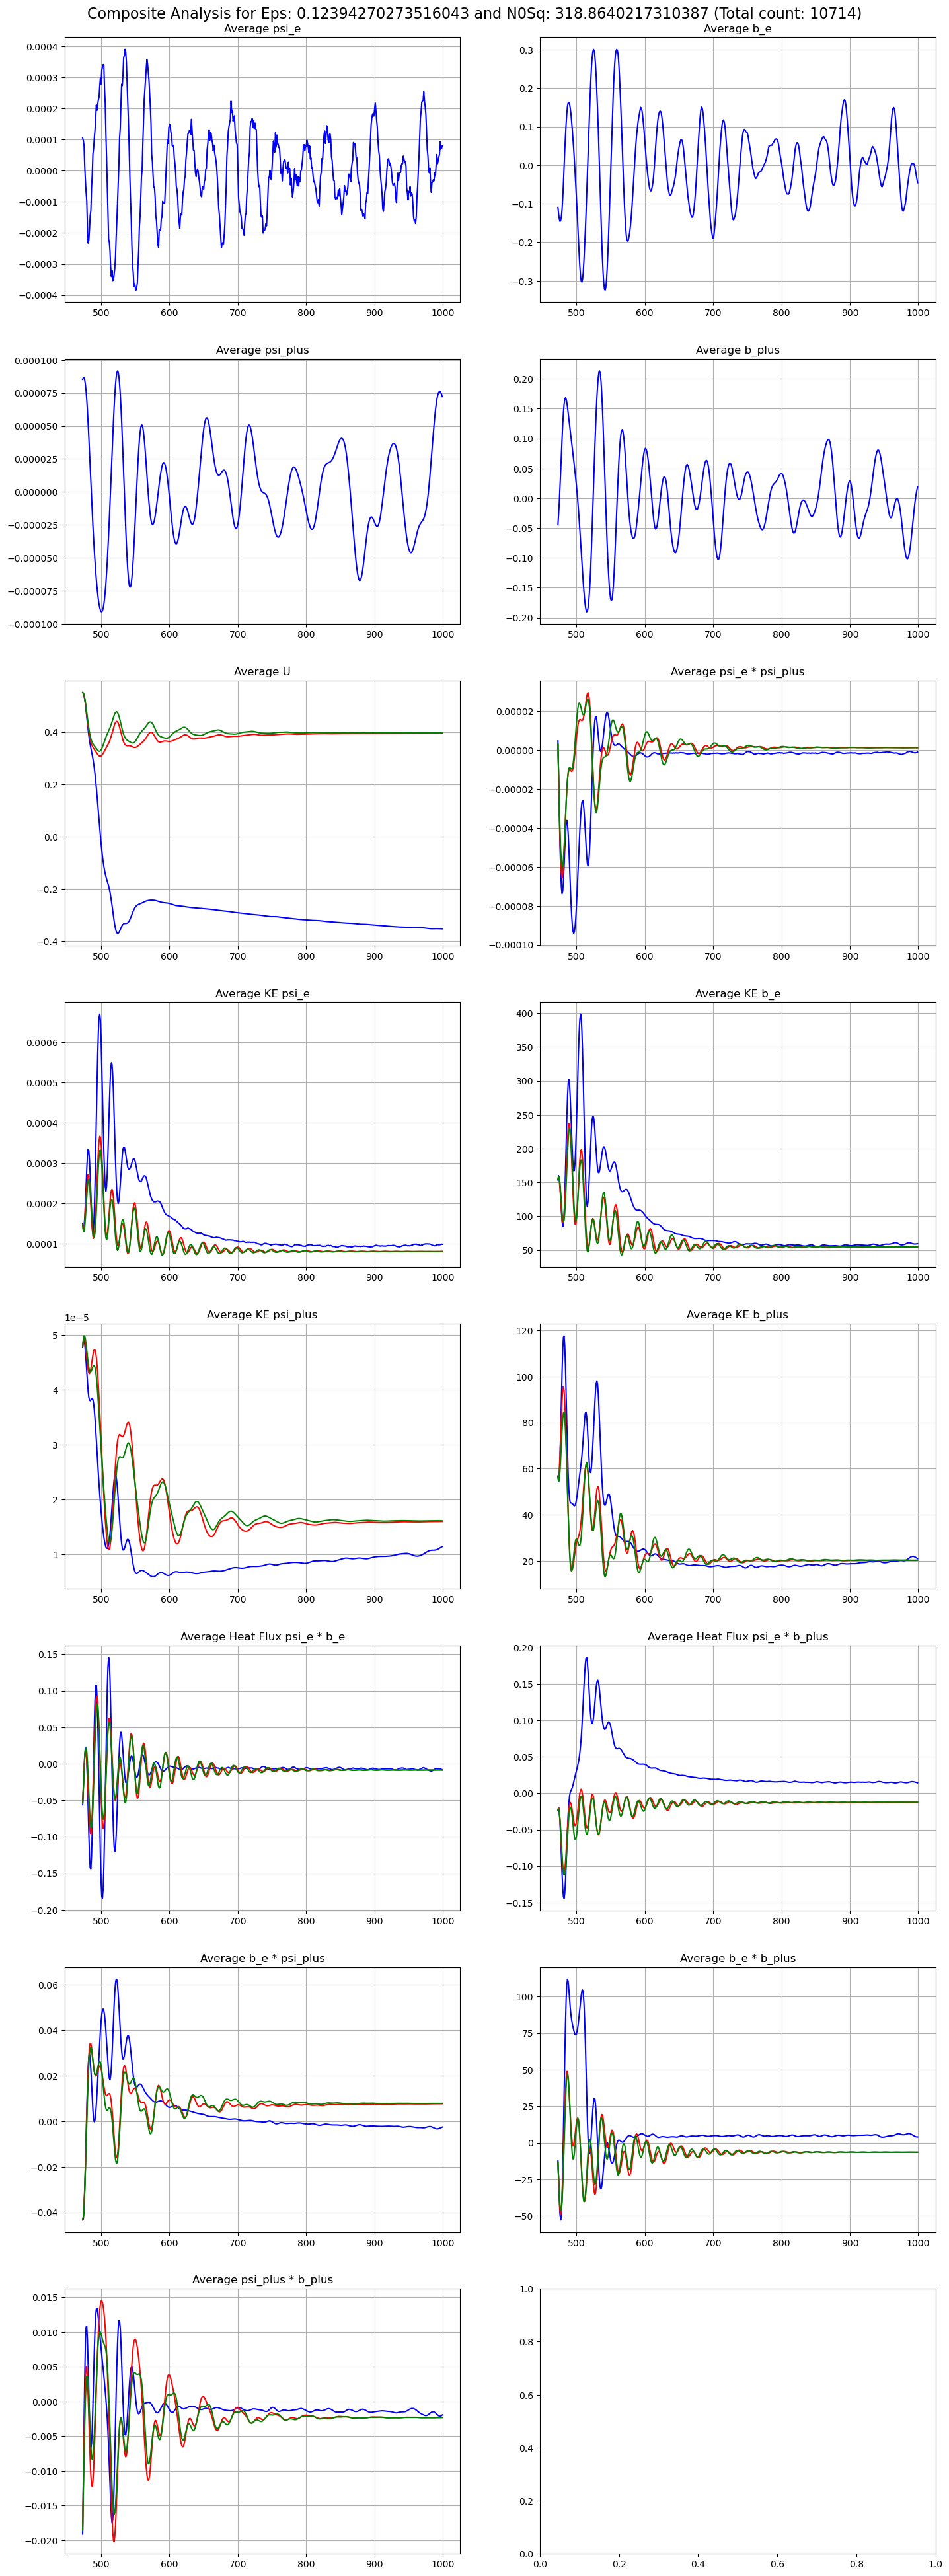

In [79]:
time_array = np.arange(473, 1000, 1)

fig, axs = plt.subplots(8, 2, figsize=(15, 40))

# for i in range(5):
#     axs[0, 0].plot(time_array, df['psi_e'][i], linewidth=0.5, linestyle='--', color='gray')
axs[0, 0].plot(time_array, average_psi_e, label='Average', linewidth=1.5, color='blue')
# axs[0, 0].plot(time_array, sims[0].C_History[0][0][:], label='Average', linewidth=1.5, color='blue')
axs[0, 0].set_title(f'Average psi_e')
axs[0, 0].grid()

# for i in range(5):
#     axs[0, 1].plot(time_array, df['b_e'][i], linewidth=0.5, linestyle='--', color='gray')
axs[0, 1].plot(time_array, average_b_e, label='Average', linewidth=1.5, color='blue')
axs[0, 1].set_title(f'Average b_e')
axs[0, 1].grid()

# for i in range(5):
#     axs[1, 0].plot(time_array, df['psi_plus'][i],linewidth=0.5, linestyle='--', color='gray') 
axs[1, 0].plot(time_array, average_psi_plus, label='Average', linewidth=1.5, color='blue')
axs[1, 0].set_title(f'Average psi_plus')
axs[1, 0].grid()

# for i in range(5):
#     axs[1, 1].plot(time_array, df['b_plus'][i], linewidth=0.5, linestyle='--', color='gray')
axs[1, 1].plot(time_array, average_b_plus, label='Average', linewidth=1.5, color='blue')
axs[1, 1].set_title(f'Average b_plus')
axs[1, 1].grid()

# for i in range(5):
#     axs[2, 0].plot(time_array, df['u_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[2, 0].plot(time_array, average_U, label='Average', linewidth=1.5, color='blue')
axs[2, 0].plot(time_array, U_CMat, label='Average', linewidth=1.5, color='red')
axs[2, 0].plot(time_array, U_tot_list, label='Average', linewidth=1.5, color='green')
axs[2, 0].set_title(f'Average U')
axs[2, 0].grid()

# for i in range(5):
#     axs[2, 1].plot(time_array, df['r_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[2, 1].plot(time_array, average_R/(0.25 * k * (k_plus_square - k_e_square)), label='Average', linewidth=1.5, color='blue')
axs[2, 1].plot(time_array, psi_e_psi_plus_list_CMat, label='Average', linewidth=1.5, color='red')
axs[2, 1].plot(time_array, psi_e_psi_plus_list_CTot, label='Average', linewidth=1.5, color='green')
axs[2, 1].set_title(f'Average psi_e * psi_plus')
axs[2, 1].grid()

# for i in range(5):
#     axs[3, 0].plot(time_array, df['k_e_psi_e_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[3, 0].plot(time_array, average_k_e_psi_e_list, label='Average', linewidth=1.5, color='blue')
axs[3, 0].plot(time_array, k_e_psi_e_list_CMat, label='Average', linewidth=1.5, color='red')
axs[3, 0].plot(time_array, k_e_psi_e_list_CTot, label='Average', linewidth=1.5, color='Green')
axs[3, 0].set_title(f'Average KE psi_e')
axs[3, 0].grid()

# for i in range(5):
#     axs[3, 1].plot(time_array, df['k_e_b_e_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[3, 1].plot(time_array, average_k_e_b_e_list, label='Average', linewidth=1.5, color='blue')
axs[3, 1].plot(time_array, k_e_b_e_list_CMat, label='Average', linewidth=1.5, color='red')
axs[3, 1].plot(time_array, k_e_b_e_list_CTot, label='Average', linewidth=1.5, color='green')
axs[3, 1].set_title(f'Average KE b_e')
axs[3, 1].grid()

# for i in range(5):
#     axs[4, 0].plot(time_array, df['k_e_psi_plus_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[4, 0].plot(time_array, average_k_e_psi_plus_list, label='Average', linewidth=1.5, color='blue')
axs[4, 0].plot(time_array, k_e_psi_plus_list_CMat, label='Average', linewidth=1.5, color='red')
axs[4, 0].plot(time_array, k_e_psi_plus_list_CTot, label='Average', linewidth=1.5, color='green')
axs[4, 0].set_title(f'Average KE psi_plus')
axs[4, 0].grid()

# for i in range(5):
#     axs[4, 1].plot(time_array, df['k_e_b_plus_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[4, 1].plot(time_array, average_k_e_b_plus_list, label='Average', linewidth=1.5, color='blue')
axs[4, 1].plot(time_array, k_e_b_plus_list_CMat, label='Average', linewidth=1.5, color='red')
axs[4, 1].plot(time_array, k_e_b_plus_list_CTot, label='Average', linewidth=1.5, color='green')
axs[4, 1].set_title(f'Average KE b_plus')
axs[4, 1].grid()

# for i in range(5):
#     axs[5, 0].plot(time_array, df['heat_flux_psi_e_b_e_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[5, 0].plot(time_array, average_heat_flux_psi_e_b_e_list, label='Average', linewidth=1.5, color='blue')
axs[5, 0].plot(time_array, heat_flux_psi_e_b_e_list_CMat, label='Average', linewidth=1.5, color='red')
axs[5, 0].plot(time_array, heat_flux_psi_e_b_e_list_CTot, label='Average', linewidth=1.5, color='green')
axs[5, 0].set_title(f'Average Heat Flux psi_e * b_e')
axs[5, 0].grid()

# for i in range(5):
#     axs[5, 1].plot(time_array, df['heat_flux_psi_e_b_plus_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[5, 1].plot(time_array, average_heat_flux_psi_e_b_plus_list, label='Average', linewidth=1.5, color='blue')
axs[5, 1].plot(time_array, heat_flux_psi_e_b_plus_list_CMat, label='Average', linewidth=1.5, color='red')
axs[5, 1].plot(time_array, heat_flux_psi_e_b_plus_list_CTot, label='Average', linewidth=1.5, color='green')
axs[5, 1].set_title(f'Average Heat Flux psi_e * b_plus')
axs[5, 1].grid()

# for i in range(5):
#     axs[6, 0].plot(time_array, df['b_e_psi_plus_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[6, 0].plot(time_array, average_b_e_psi_plus_list, label='Average', linewidth=1.5, color='blue')
axs[6, 0].plot(time_array, b_e_psi_plus_list_CMat, label='Average', linewidth=1.5, color='red')
axs[6, 0].plot(time_array, b_e_psi_plus_list_CTot, label='Average', linewidth=1.5, color='green')
axs[6, 0].set_title(f'Average b_e * psi_plus')
axs[6, 0].grid()

# for i in range(5):
#     axs[6, 1].plot(time_array, df['b_e_b_plus_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[6, 1].plot(time_array, average_b_e_b_plus_list, label='Average', linewidth=1.5, color='blue')
axs[6, 1].plot(time_array, b_e_b_plus_list_CMat, label='Average', linewidth=1.5, color='red')
axs[6, 1].plot(time_array, b_e_b_plus_list_CTot, label='Average', linewidth=1.5, color='green')
axs[6, 1].set_title(f'Average b_e * b_plus')
axs[6, 1].grid()

# for i in range(5):
#     axs[7, 0].plot(time_array, df['psi_plus_b_plus_list'][i], linewidth=0.5, linestyle='--', color='gray')
axs[7, 0].plot(time_array, average_psi_plus_b_plus_list, label='Average', linewidth=1.5, color='blue')
axs[7, 0].plot(time_array, psi_plus_b_plus_list_CMat, label='Average', linewidth=1.5, color='red')
axs[7, 0].plot(time_array, psi_plus_b_plus_list_CTot, label='Average', linewidth=1.5, color='green')
axs[7, 0].set_title(f'Average psi_plus * b_plus')
axs[7, 0].grid()



plt.suptitle(f'Composite Analysis for Eps: {epsilon} and N0Sq: {N_0_squared} (Total count: {len(list(df['b_e']))})', fontsize=16)
plt.subplots_adjust(wspace=0.3, hspace=0.3, top=1.85)

plt.tight_layout(pad = 3)

plt.show()